In [1]:
import sys
print(sys.executable)

/home/sherry/anaconda3/envs/graph/bin/python


In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn import plotting
from openpyxl import load_workbook
import networkx as nx
import itertools
import gmatch4py as gm
from sklearn.cluster import SpectralClustering
import seaborn as sns
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy import stats
from scipy.spatial import distance
from sklearn import decomposition

In [3]:
DATA_PATH = '/home/sherry/Dropbox/PhD/Data/PNC_Enriched/PNC_Connectomes_wSubcort'
LABEL_PATH = '/home/sherry/Dropbox/PhD/Data/PNC_Enriched/PNC_Connectomes_GO1_n968_LTN_dtiQApass_t1QApass_fsQApass.xlsx'
COG_PATH = '/home/sherry/Dropbox/PhD/Data/PNC_Enriched/PNC_Connectomes_n1601_cnb_factor_scores_tymoore_20151006.xlsx'
N_NODE = 118

In [4]:
workbook = load_workbook(LABEL_PATH)
sheet = workbook[workbook.sheetnames[0]]
data = sheet.values
cols = next(data)[0:]
data = list(data)
data = (itertools.islice(r, 0, None) for r in data)
df_label = pd.DataFrame(data, columns = cols)
df_label

/home/sherry/anaconda3/envs/graph/lib/python3.7/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


,Subject,bblid,scanid,ScanAgeYears,Sex
0,080199_002637,80199,2637,20.333,M
1,080812_002646,80812,2646,20.583,F
2,080607_002647,80607,2647,21.000,M
3,080854_002675,80854,2675,20.167,M
4,081826_002682,81826,2682,19.083,F
...,...,...,...,...,...
963,128913_008435,128913,8435,10.417,F
964,122895_008449,122895,8449,10.750,F
965,139469_008450,139469,8450,8.917,F
966,139272_008456,139272,8456,18.917,F


In [5]:
workbook = load_workbook(COG_PATH)
sheet = workbook[workbook.sheetnames[0]]
data = sheet.values
cols = next(data)[0:]
data = list(data)
data = (itertools.islice(r, 0, None) for r in data)
df_cog = pd.DataFrame(data, columns = cols)
df = df_label.merge(df_cog, on='Subject')
df

,Subject,bblid,scanid,ScanAgeYears,Sex,Overall_Efficiency,Overall_Accuracy,Overall_Speed,F1_Exec_Comp_Res_Accuracy,F2_Social_Cog_Accuracy,...,F1_Exec_Comp_Cog_Accuracy_Ar,F2_Social_Cog_Accuracy_Ar,F3_Memory_Accuracy_Ar,F1_Social_Cognition_Efficiency_Ar,F2_Complex_Reasoning_Efficiency_Ar,F3_Memory_Efficiency_Ar,F4_Executive_Efficiency_Ar,F1_Slow_Speed_Ar,F2_Memory_Speed_Ar,F3_Fast_Speed_Ar
0,080199_002637,80199,2637,20.333,M,0.772291,0.580977,0.880618,0.455189,1.375420,...,-0.262102,0.951817,-0.729813,1.309180,0.323467,-0.216490,-0.439120,0.882288,0.621913,-0.233789
1,080812_002646,80812,2646,20.583,F,1.301177,1.127330,1.013718,1.040810,1.330917,...,0.454563,0.892760,0.400804,1.000376,1.442359,0.554244,0.390312,0.891195,0.657851,0.582442
2,080607_002647,80607,2647,21.000,M,0.286403,-0.166606,0.867489,-0.589465,0.349593,...,-1.700007,-0.419078,-0.669416,0.161091,-1.107295,0.241034,-0.233995,0.862486,0.864056,-0.557817
3,080854_002675,80854,2675,20.167,M,1.214104,0.831975,0.784795,1.109957,0.792038,...,0.647779,0.287444,-1.371715,1.056468,1.638448,-1.279257,0.728730,1.249609,-0.136509,0.333181
4,081826_002682,81826,2682,19.083,F,0.658344,0.701067,0.797432,0.863827,0.188943,...,0.394165,-0.445431,0.387097,-0.140397,0.684000,1.078564,-0.618809,0.299570,1.109254,-0.971033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,128913_008435,128913,8435,10.417,F,-0.712246,-0.569068,-0.438520,-0.261823,-1.658564,...,1.064047,-0.808203,0.442814,-0.138470,0.957842,0.277516,1.245037,0.777936,0.409998,-0.068248
964,122895_008449,122895,8449,10.750,F,-0.882092,-0.668601,-0.584834,-0.636302,-0.554835,...,0.642309,0.629783,-0.335251,0.720055,0.988265,-0.562909,0.727081,0.874502,0.187113,-0.403543
965,139469_008450,139469,8450,8.917,F,-1.526000,-1.071063,-1.241007,-0.860672,-1.952560,...,0.321335,-1.138056,0.633449,-1.163060,-0.661444,0.357749,0.585915,-0.747036,-0.224689,0.334851
966,139272_008456,139272,8456,18.917,F,0.112258,-0.254239,0.331829,-0.357341,-0.711575,...,-1.065160,-1.436878,0.149712,-0.329351,-0.136353,0.178420,-1.404730,0.668937,-0.024057,-1.707187


In [6]:
#subj_list = [x for x in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, x))]
subj_list = np.loadtxt(os.path.join(DATA_PATH, 'IntersectionList.txt'), dtype=str)
#print(subj_list)
filelist = os.listdir(os.path.join(DATA_PATH, subj_list[0]))
filelist.sort()
df = df.set_index('Subject')
df = df.loc[subj_list]
df = df.reset_index()
df

,Subject,bblid,scanid,ScanAgeYears,Sex,Overall_Efficiency,Overall_Accuracy,Overall_Speed,F1_Exec_Comp_Res_Accuracy,F2_Social_Cog_Accuracy,...,F1_Exec_Comp_Cog_Accuracy_Ar,F2_Social_Cog_Accuracy_Ar,F3_Memory_Accuracy_Ar,F1_Social_Cognition_Efficiency_Ar,F2_Complex_Reasoning_Efficiency_Ar,F3_Memory_Efficiency_Ar,F4_Executive_Efficiency_Ar,F1_Slow_Speed_Ar,F2_Memory_Speed_Ar,F3_Fast_Speed_Ar
0,104848_004021,104848,4021,9.333,M,-2.653646,-0.553921,-3.910421,-0.171667,-1.576187,...,1.009712,-0.767816,-0.264849,-1.874661,0.446218,-2.681734,-2.289818,-1.862693,-3.199088,-4.179434
1,096118_003500,96118,3500,12.750,F,-0.715471,-0.335380,-0.771795,-0.837502,0.003914,...,-0.978209,0.137709,1.291961,-1.146359,-2.098182,1.372819,-0.711722,-1.877799,0.098023,-0.921030
2,089786_003374,89786,3374,15.000,F,0.545471,0.103866,0.625997,0.101847,0.450649,...,-0.172187,0.197136,-0.438456,0.652406,-0.017963,-0.115064,-0.179959,0.541660,0.290331,-0.355258
3,084002_008415,84002,8415,22.250,M,1.173255,1.256074,0.485205,1.149940,1.419740,...,0.614987,1.004484,0.485705,0.654913,0.470248,0.168938,0.968130,0.008785,0.045640,0.812169
4,118513_005409,118513,5409,17.917,M,1.524771,1.676928,0.900182,1.423086,2.210197,...,0.988091,2.034596,0.171513,1.686030,0.868904,-0.236525,1.280882,0.436948,0.278124,0.923202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,127104_006609,127104,6609,18.583,F,0.761541,1.408620,0.015364,1.134530,1.598740,...,0.648972,1.266752,0.590299,1.045653,0.074405,-0.020112,-0.149322,0.064060,-0.254299,-1.149920
815,118807_008351,118807,8351,14.083,M,0.236954,0.018397,0.136934,0.179985,-0.822101,...,0.443958,-0.779257,0.181545,-0.127086,0.470268,-0.372238,1.057783,0.396101,-0.299761,0.499119
816,090050_004746,90050,4746,16.500,M,0.034860,0.263985,-0.129999,0.059641,0.844325,...,-0.424307,0.579625,-0.590891,-0.094879,-0.791280,-0.313816,-0.488425,-0.872872,0.020465,-0.497376
817,088412_004410,88412,4410,15.167,F,-0.070488,-0.496581,0.467241,-0.563000,-0.506371,...,-1.070067,-1.093180,-0.688801,-1.208924,-1.145344,0.254091,0.443247,-0.265995,0.652783,0.165584


In [7]:
if N_NODE is not None:
    filelist = [x for x in filelist if str(N_NODE) in x.split('_')]
print(filelist)
conn_dict = {}
for subj in subj_list:
    sconn = []
    fconn = []
    for file in filelist:
        filepath = os.path.join(DATA_PATH, subj, file)
        if file.startswith('DTI'):
            sconn.append(np.loadtxt(filepath))
        elif file.startswith('Restbold'):
            fconn.append(np.loadtxt(filepath))
        else:
            print('Not recognized')
    fconn = ConnectivityMeasure(kind='correlation').fit_transform(fconn)
    conn_dict[subj] = {'sconn': sconn, 'fconn': fconn}

['Probabilistic_det_10M_nonnormalized_118_sift2.txt', 'Probabilistic_det_10M_nonnormalized_118_sift2_nodevol.txt', 'Probabilistic_prob_10M_nonnormalized_118_sift2.txt', 'Probabilistic_prob_10M_nonnormalized_118_sift2_nodevol.txt', 'Restbold_118_full.txt']


In [8]:
conn_dict['104848_004021']['fconn']

array([[[ 1.        ,  0.27510451,  0.18235615, ..., -0.11883097,
         -0.6078877 , -0.8100962 ],
        [ 0.27510451,  1.        ,  0.75324131, ...,  0.48113601,
         -0.12420858, -0.40817726],
        [ 0.18235615,  0.75324131,  1.        , ...,  0.68321079,
          0.12741661, -0.38520752],
        ...,
        [-0.11883097,  0.48113601,  0.68321079, ...,  1.        ,
          0.44457212, -0.0985002 ],
        [-0.6078877 , -0.12420858,  0.12741661, ...,  0.44457212,
          1.        ,  0.58008003],
        [-0.8100962 , -0.40817726, -0.38520752, ..., -0.0985002 ,
          0.58008003,  1.        ]]])

In [9]:
q = df['ScanAgeYears'].quantile([0.25, 0.5, 0.75])
df_age_extreme = df[(df['ScanAgeYears'] > q[0.75]) | (df['ScanAgeYears'] < q[0.25])]
subj_list_extreme = df_age_extreme['Subject'].tolist()
df_age_extreme

,Subject,bblid,scanid,ScanAgeYears,Sex,Overall_Efficiency,Overall_Accuracy,Overall_Speed,F1_Exec_Comp_Res_Accuracy,F2_Social_Cog_Accuracy,...,F1_Exec_Comp_Cog_Accuracy_Ar,F2_Social_Cog_Accuracy_Ar,F3_Memory_Accuracy_Ar,F1_Social_Cognition_Efficiency_Ar,F2_Complex_Reasoning_Efficiency_Ar,F3_Memory_Efficiency_Ar,F4_Executive_Efficiency_Ar,F1_Slow_Speed_Ar,F2_Memory_Speed_Ar,F3_Fast_Speed_Ar
0,104848_004021,104848,4021,9.333,M,-2.653646,-0.553921,-3.910421,-0.171667,-1.576187,...,1.009712,-0.767816,-0.264849,-1.874661,0.446218,-2.681734,-2.289818,-1.862693,-3.199088,-4.179434
1,096118_003500,96118,3500,12.750,F,-0.715471,-0.335380,-0.771795,-0.837502,0.003914,...,-0.978209,0.137709,1.291961,-1.146359,-2.098182,1.372819,-0.711722,-1.877799,0.098023,-0.921030
3,084002_008415,84002,8415,22.250,M,1.173255,1.256074,0.485205,1.149940,1.419740,...,0.614987,1.004484,0.485705,0.654913,0.470248,0.168938,0.968130,0.008785,0.045640,0.812169
10,125506_006370,125506,6370,19.000,M,-0.412329,-0.399211,-0.330765,-0.297182,0.179239,...,-1.108395,-0.507357,-2.201178,-0.925715,-0.762559,-1.564103,-0.903103,-0.536803,-0.079549,-1.503836
14,109600_004264,109600,4264,10.417,M,-0.719771,-1.032115,0.133167,-1.213241,-0.049261,...,-0.863064,0.627832,-0.648999,0.409573,-0.841519,0.150986,-0.246397,0.216703,0.745941,0.657341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,082989_002967,82989,2967,18.833,M,0.681993,0.643727,0.453330,0.945212,0.261740,...,0.479196,-0.368075,-0.687415,0.288749,0.723427,-1.016240,0.554498,0.592852,-0.135207,0.464969
812,132470_006393,132470,6393,10.000,M,-0.804694,-0.961792,-0.102765,-0.815313,-0.504927,...,0.005948,0.362783,-0.166643,0.082493,-0.076893,0.744448,-0.108855,-0.051925,0.971937,0.320817
813,126741_005882,126741,5882,11.417,F,0.347677,-0.410030,0.768335,-0.658796,-0.035182,...,-0.420921,0.401871,0.667235,0.864682,-0.515220,1.388861,0.825795,0.451769,1.189877,1.148596
814,127104_006609,127104,6609,18.583,F,0.761541,1.408620,0.015364,1.134530,1.598740,...,0.648972,1.266752,0.590299,1.045653,0.074405,-0.020112,-0.149322,0.064060,-0.254299,-1.149920


In [10]:
'''
def edge_subst_cost(e1, e2):
    return abs(e1['weight'] - e2['weight']) / (abs(e1['weight']) + abs(e2['weight']))


ged1 = np.zeros((len(subj_list), len(subj_list)))
for i in range(len(subj_list[0:1])):
    for j in range(i+1, len(subj_list[0:2])):
        G1 = nx.from_numpy_array(conn_dict[subj_list[i]]['sconn'][0])
        G2 = nx.from_numpy_array(conn_dict[subj_list[j]]['sconn'][0])
        for v in nx.optimize_graph_edit_distance(G1, G2, node_match=None, edge_match=None,
                                           node_subst_cost=None, node_del_cost=None, node_ins_cost=None,
                                           edge_subst_cost=, edge_del_cost=None, edge_ins_cost=None,
                                           upper_bound=None):
            ged1[i,j] = v
'''

# graph edit distance for structural connectivity
# node deletion & addition cost is 1, node substisution cost is 0 (node attributes are not considered)
# edge deletion & addition cost is 1

print('Create graphs...')
Glist = []
for subj in subj_list_extreme:
    Glist.append(nx.from_numpy_array(conn_dict[subj]['sconn'][0]))

print('Compute edit distance...')
ged_fun = gm.GraphEditDistance(1,1,1,1)
ged_extreme = ged_fun.compare(Glist,None)
ged_extreme_sim = ged_fun.similarity(ged_extreme)

Create graphs...
Compute edit distance...


In [12]:
print(ged_extreme_sim)
np.savetxt('graph_distance.txt', ged_extreme_sim)

[[1.         0.02542373 0.02542373 ... 0.03389831 0.04237288 0.01694915]
 [0.02542373 1.         0.05932203 ... 0.05084746 0.05932203 0.05084746]
 [0.02542373 0.05932203 1.         ... 0.02542373 0.04237288 0.04237288]
 ...
 [0.03389831 0.05084746 0.02542373 ... 1.         0.03389831 0.01694915]
 [0.04237288 0.05932203 0.04237288 ... 0.03389831 1.         0.07627119]
 [0.01694915 0.05084746 0.04237288 ... 0.01694915 0.07627119 1.        ]]


In [10]:
#ged_extreme_sim = np.loadtxt('graph_distance.txt')

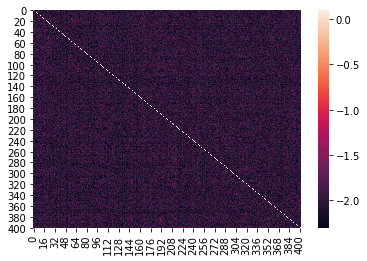

In [17]:
sns.heatmap(np.log(ged_extreme_sim+0.1))

In [26]:
clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(ged_extreme_sim)
print(clustering.labels_)

[0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0
 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1
 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0
 0 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1
 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1
 1 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1
 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0]


/home/sherry/anaconda3/envs/graph/lib/python3.7/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [27]:
pca = decomposition.PCA(n_components=2).fit(ged_extreme_sim)
embeddings_pca = pca.transform(ged_extreme_sim)
print(embeddings_pca.shape)

(402, 2)


In [29]:
embeddings = TSNE(n_components=2, n_jobs=8).fit_transform(ged_extreme_sim)
print(embeddings.shape)

(402, 2)


In [30]:
ged_label = pd.DataFrame({'Subject': subj_list_extreme,
                          'GEDLabel': clustering.labels_,
                          'TSNE1': list(embeddings[:, 0]),
                          'TSNE2': list(embeddings[:, 1]),
                          'PCA1': list(embeddings_pca[:, 0]),
                          'PCA2': list(embeddings_pca[:, 1])})
df_ged = df.merge(ged_label, on='Subject') 

In [31]:
df_ged['GTLabel'] = 1*(df_ged['ScanAgeYears'] < q[0.5])
df_ged

,Subject,bblid,scanid,ScanAgeYears,Sex,Overall_Efficiency,Overall_Accuracy,Overall_Speed,F1_Exec_Comp_Res_Accuracy,F2_Social_Cog_Accuracy,...,F4_Executive_Efficiency_Ar,F1_Slow_Speed_Ar,F2_Memory_Speed_Ar,F3_Fast_Speed_Ar,GEDLabel,TSNE1,TSNE2,PCA1,PCA2,GTLabel
0,104848_004021,104848,4021,9.333,M,-2.653646,-0.553921,-3.910421,-0.171667,-1.576187,...,-2.289818,-1.862693,-3.199088,-4.179434,0,1.524094,0.387193,-0.055642,0.074621,1
1,096118_003500,96118,3500,12.750,F,-0.715471,-0.335380,-0.771795,-0.837502,0.003914,...,-0.711722,-1.877799,0.098023,-0.921030,0,-6.732956,2.049140,-0.016378,-0.027226,1
2,084002_008415,84002,8415,22.250,M,1.173255,1.256074,0.485205,1.149940,1.419740,...,0.968130,0.008785,0.045640,0.812169,1,-6.896045,-2.520758,0.091698,0.001324,0
3,125506_006370,125506,6370,19.000,M,-0.412329,-0.399211,-0.330765,-0.297182,0.179239,...,-0.903103,-0.536803,-0.079549,-1.503836,1,-4.085204,7.336016,0.089742,0.008055,0
4,109600_004264,109600,4264,10.417,M,-0.719771,-1.032115,0.133167,-1.213241,-0.049261,...,-0.246397,0.216703,0.745941,0.657341,0,-1.328127,3.896548,-0.103638,0.034822,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,082989_002967,82989,2967,18.833,M,0.681993,0.643727,0.453330,0.945212,0.261740,...,0.554498,0.592852,-0.135207,0.464969,1,6.873582,-7.793213,0.034858,-0.066276,0
398,132470_006393,132470,6393,10.000,M,-0.804694,-0.961792,-0.102765,-0.815313,-0.504927,...,-0.108855,-0.051925,0.971937,0.320817,1,-2.345238,0.476262,0.119686,0.096796,1
399,126741_005882,126741,5882,11.417,F,0.347677,-0.410030,0.768335,-0.658796,-0.035182,...,0.825795,0.451769,1.189877,1.148596,0,-4.012187,3.111520,-0.086543,0.084527,1
400,127104_006609,127104,6609,18.583,F,0.761541,1.408620,0.015364,1.134530,1.598740,...,-0.149322,0.064060,-0.254299,-1.149920,1,0.853133,-5.842598,0.103569,0.018514,0


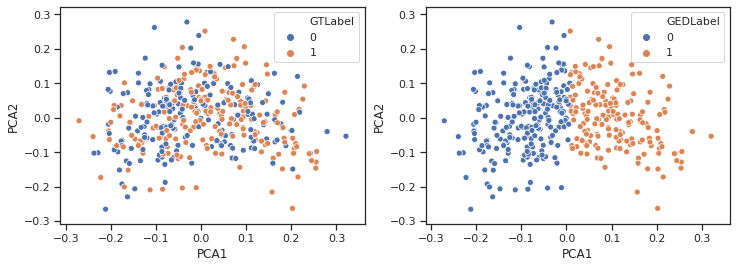

In [147]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.scatterplot(x='PCA1', y='PCA2', data=df_ged, hue=df_ged['GTLabel'])
plt.subplot(1,2,2)
sns.scatterplot(x='PCA1', y='PCA2', data=df_ged, hue=df_ged['GEDLabel'])

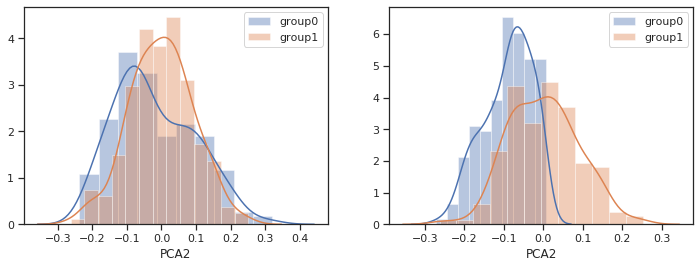

In [148]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.distplot(df_ged[df_ged['GTLabel'] == 0]['PCA1'], kde=True, label='group0')
sns.distplot(df_ged[df_ged['GTLabel'] == 1]['PCA2'], kde=True, label='group1')
plt.legend()
plt.subplot(1,2,2)
sns.distplot(df_ged[df_ged['GEDLabel'] == 0]['PCA1'], kde=True, label='group0')
sns.distplot(df_ged[df_ged['GEDLabel'] == 1]['PCA2'], kde=True, label='group1')
plt.legend()

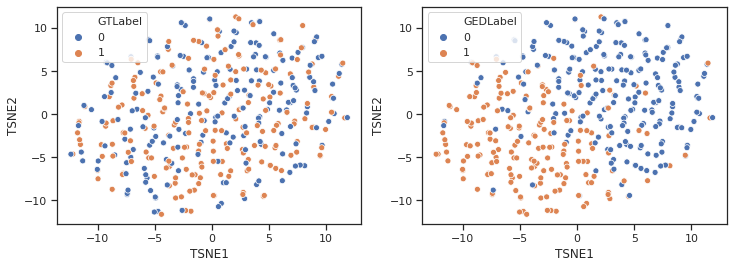

In [149]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.scatterplot(x='TSNE1', y='TSNE2', data=df_ged, hue=df_ged['GTLabel'])
plt.subplot(1,2,2)
sns.scatterplot(x='TSNE1', y='TSNE2', data=df_ged, hue=df_ged['GEDLabel'])

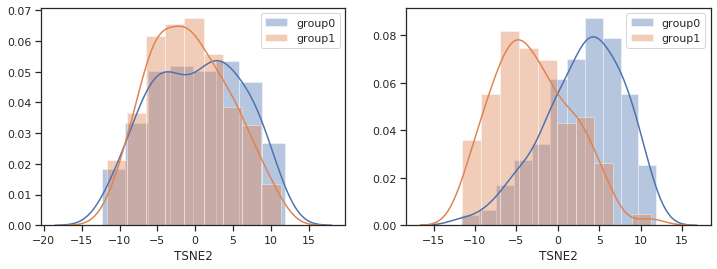

In [150]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sns.distplot(df_ged[df_ged['GTLabel'] == 0]['TSNE1'], kde=True, label='group0')
sns.distplot(df_ged[df_ged['GTLabel'] == 1]['TSNE2'], kde=True, label='group1')
plt.legend()
plt.subplot(1,2,2)
sns.distplot(df_ged[df_ged['GEDLabel'] == 0]['TSNE1'], kde=True, label='group0')
sns.distplot(df_ged[df_ged['GEDLabel'] == 1]['TSNE2'], kde=True, label='group1')
plt.legend()

In [156]:
accuracy = (df_ged['GEDLabel'] == df_ged['GTLabel']).sum()/len(df_ged)
print(accuracy)

0.572139303482587


-------------------------Mean-------------------------
GEDLabel
0    15.991659
1    14.617670
Name: ScanAgeYears, dtype: float64
-------------------------Std-------------------------
GEDLabel
0    4.439157
1    4.349578
Name: ScanAgeYears, dtype: float64
Ttest_indResult(statistic=-3.1233241431114473, pvalue=0.0019221718259442113)


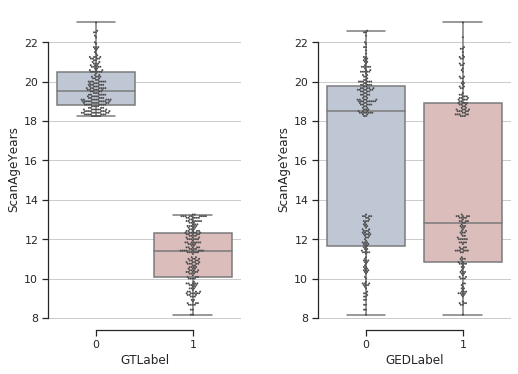

In [151]:
print('-------------------------Mean-------------------------')
print(df_ged.groupby('GEDLabel')['ScanAgeYears'].mean())
print('-------------------------Std-------------------------')
print(df_ged.groupby('GEDLabel')['ScanAgeYears'].std())
SA_g1 = df_ged[df_ged['GEDLabel'] == 1]['ScanAgeYears']
SA_g0 = df_ged[df_ged['GEDLabel'] == 0]['ScanAgeYears'].dropna()
print(stats.ttest_ind(SA_g1, SA_g0, equal_var=False))

sns.set(style='ticks')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
sns.boxplot(x='GTLabel', y='ScanAgeYears', data=df_ged, whis='range', palette='vlag', ax=ax[0])
sns.swarmplot(x='GTLabel', y='ScanAgeYears', data=df_ged, size=2, color='.3', linewidth=0, ax=ax[0])
#ax[0].stripplot(x='GEDLabel', y='ScanAgeYears', data=df_ged, size=5, jitter = 0.1)
ax[0].yaxis.grid(True)
ax[0].set(xlabel='GTLabel')

sns.boxplot(x='GEDLabel', y='ScanAgeYears', data=df_ged, whis='range', palette='vlag', ax=ax[1])
sns.swarmplot(x='GEDLabel', y='ScanAgeYears', data=df_ged, size=2, color='.3', linewidth=0, ax=ax[1])
#ax[1] = sns.stripplot(x='GEDLabel', y='ScanAgeYears', data=df_ged, size=5, jitter = 0.1)
ax[1].yaxis.grid(True)
ax[1].set(xlabel='GEDLabel')
sns.despine(trim=True)
plt.tight_layout(pad=3.0)

-------------------------Mean-------------------------
GEDLabel
0    0.239126
1    0.085028
Name: Overall_Accuracy, dtype: float64
-------------------------Std-------------------------
GEDLabel
0    0.871917
1    0.979894
Name: Overall_Accuracy, dtype: float64
Ttest_indResult(statistic=-1.6461485801816191, pvalue=0.10059158506803838)


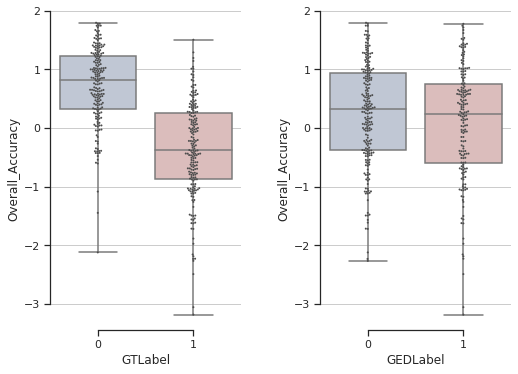

In [152]:
print('-------------------------Mean-------------------------')
print(df_ged.groupby('GEDLabel')['Overall_Accuracy'].mean())
print('-------------------------Std-------------------------')
print(df_ged.groupby('GEDLabel')['Overall_Accuracy'].std())
OA_g1 = df_ged[df_ged['GEDLabel'] == 1]['Overall_Accuracy']
OA_g0 = df_ged[df_ged['GEDLabel'] == 0]['Overall_Accuracy'].dropna()
print(stats.ttest_ind(OA_g1, OA_g0, equal_var=False))

sns.set(style='ticks')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
sns.boxplot(x='GTLabel', y='Overall_Accuracy', data=df_ged, whis='range', palette='vlag', ax=ax[0])
sns.swarmplot(x='GTLabel', y='Overall_Accuracy', data=df_ged, size=2, color='.3', linewidth=0, ax=ax[0])
#ax[0].stripplot(x='GEDLabel', y='Overall_Accuracy', data=df_ged, size=5, jitter = 0.1)
ax[0].yaxis.grid(True)
ax[0].set(xlabel='GTLabel')

sns.boxplot(x='GEDLabel', y='Overall_Accuracy', data=df_ged, whis='range', palette='vlag', ax=ax[1])
sns.swarmplot(x='GEDLabel', y='Overall_Accuracy', data=df_ged, size=2, color='.3', linewidth=0, ax=ax[1])
#ax[1] = sns.stripplot(x='GEDLabel', y='Overall_Accuracy', data=df_ged, size=5, jitter = 0.1)
ax[1].yaxis.grid(True)
ax[1].set(xlabel='GEDLabel')
sns.despine(trim=True)
plt.tight_layout(pad=3.0)

-------------------------Mean-------------------------
GEDLabel
0    0.195016
1    0.033088
Name: Overall_Efficiency, dtype: float64
-------------------------Std-------------------------
GEDLabel
0    0.934018
1    0.974002
Name: Overall_Efficiency, dtype: float64
Ttest_indResult(statistic=-1.6869037557463251, pvalue=0.09244430190879993)


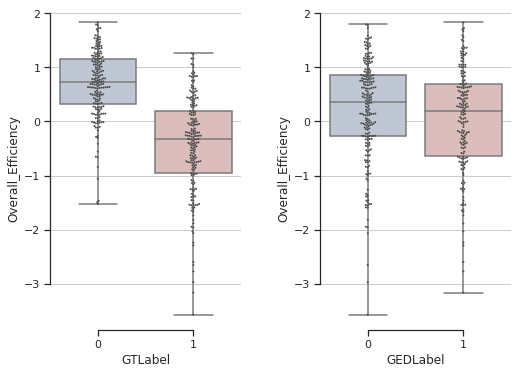

In [166]:
print('-------------------------Mean-------------------------')
print(df_ged.groupby('GEDLabel')['Overall_Efficiency'].mean())
print('-------------------------Std-------------------------')
print(df_ged.groupby('GEDLabel')['Overall_Efficiency'].std())
OE_g1 = df_ged[df_ged['GEDLabel'] == 1]['Overall_Efficiency']
OE_g0 = df_ged[df_ged['GEDLabel'] == 0]['Overall_Efficiency'].dropna()
print(stats.ttest_ind(OE_g1, OE_g0, equal_var=False))

sns.set(style='ticks')
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))
sns.boxplot(x='GTLabel', y='Overall_Efficiency', data=df_ged, whis='range', palette='vlag', ax=ax[0])
sns.swarmplot(x='GTLabel', y='Overall_Efficiency', data=df_ged, size=2, color='.3', linewidth=0, ax=ax[0])
#ax[0].stripplot(x='GEDLabel', y='Overall_Efficiency', data=df_ged, size=5, jitter = 0.1)
ax[0].yaxis.grid(True)
ax[0].set(xlabel='GTLabel')

sns.boxplot(x='GEDLabel', y='Overall_Efficiency', data=df_ged, whis='range', palette='vlag', ax=ax[1])
sns.swarmplot(x='GEDLabel', y='Overall_Efficiency', data=df_ged, size=2, color='.3', linewidth=0, ax=ax[1])
#ax[1] = sns.stripplot(x='GEDLabel', y='Overall_Efficiency', data=df_ged, size=5, jitter = 0.1)
ax[1].yaxis.grid(True)
ax[1].set(xlabel='GEDLabel')
sns.despine(trim=True)
plt.tight_layout(pad=3.0)

In [165]:
columns = ['ScanAgeYears', 'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed']
df_test = {'column':[], 't-test_stats':[], 't-test_p':[], 'welch_stats':[], 'welch_p':[], 'mannwhitneyu_stats':[], 'mannwhitneyu_p':[]}
for column in columns:
    df_test['column'].append(column)
    g0 = df_ged[df_ged['GEDLabel'] == 0][column].dropna()
    g1 = df_ged[df_ged['GEDLabel'] == 1][column].dropna()

    statistics, p = stats.ttest_ind(g1, g0)
    df_test['t-test_stats'].append(statistics)
    df_test['t-test_p'].append(p)
    
    statistics, p = stats.ttest_ind(g1, g0, equal_var=False)
    df_test['welch_stats'].append(statistics)
    df_test['welch_p'].append(p)

    statistics, p = stats.mannwhitneyu(g1, g0)
    df_test['mannwhitneyu_stats'].append(statistics)
    df_test['mannwhitneyu_p'].append(p)

pd.DataFrame(df_test).set_index('column')

,t-test_stats,t-test_p,welch_stats,welch_p,mannwhitneyu_stats,mannwhitneyu_p
column,,,,,,
ScanAgeYears,-3.117297,0.001957,-3.123324,0.001922,16304.0,0.000677
Overall_Efficiency,-1.693292,0.091182,-1.686904,0.092444,17746.0,0.034654
Overall_Accuracy,-1.663502,0.096999,-1.646149,0.100592,18307.0,0.091892
Overall_Speed,-1.136737,0.256332,-1.139147,0.255344,18113.0,0.067109


In [167]:
columns = ['ScanAgeYears', 'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed']
df_test = {'column':[], 't-test_stats':[], 't-test_p':[], 'welch_stats':[], 'welch_p':[], 'mannwhitneyu_stats':[], 'mannwhitneyu_p':[]}
for column in columns:
    df_test['column'].append(column)
    g0 = df_ged[df_ged['GTLabel'] == 0][column].dropna()
    g1 = df_ged[df_ged['GTLabel'] == 1][column].dropna()

    statistics, p = stats.ttest_ind(g1, g0)
    df_test['t-test_stats'].append(statistics)
    df_test['t-test_p'].append(p)
    
    statistics, p = stats.ttest_ind(g1, g0, equal_var=False)
    df_test['welch_stats'].append(statistics)
    df_test['welch_p'].append(p)

    statistics, p = stats.mannwhitneyu(g1, g0)
    df_test['mannwhitneyu_stats'].append(statistics)
    df_test['mannwhitneyu_p'].append(p)

pd.DataFrame(df_test).set_index('column')

,t-test_stats,t-test_p,welch_stats,welch_p,mannwhitneyu_stats,mannwhitneyu_p
column,,,,,,
ScanAgeYears,-68.828071,7.640198e-224,-69.070161,1.419577e-218,0.0,1.144783e-67
Overall_Efficiency,-14.574334,7.358523e-39,-14.626597,2.715770e-38,5641.0,1.040738e-35
Overall_Accuracy,-14.716565,1.889043e-39,-14.751214,2.900035e-39,5678.5,1.560253e-35
Overall_Speed,-9.074355,5.338400e-18,-9.098324,5.444060e-18,9902.0,1.245655e-18


In [168]:
columns = ['ScanAgeYears', 'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed']
df_test = {'column':[], 't-test_stats':[], 't-test_p':[], 'welch_stats':[], 'welch_p':[], 'mannwhitneyu_stats':[], 'mannwhitneyu_p':[]}
for column in columns:
    df_test['column'].append(column)
    g0 = df_ged[df_ged['Sex'] == 'M'][column].dropna()
    g1 = df_ged[df_ged['Sex'] == 'F'][column].dropna()

    statistics, p = stats.ttest_ind(g1, g0)
    df_test['t-test_stats'].append(statistics)
    df_test['t-test_p'].append(p)
    
    statistics, p = stats.ttest_ind(g1, g0, equal_var=False)
    df_test['welch_stats'].append(statistics)
    df_test['welch_p'].append(p)

    statistics, p = stats.mannwhitneyu(g1, g0)
    df_test['mannwhitneyu_stats'].append(statistics)
    df_test['mannwhitneyu_p'].append(p)

pd.DataFrame(df_test).set_index('column')

,t-test_stats,t-test_p,welch_stats,welch_p,mannwhitneyu_stats,mannwhitneyu_p
column,,,,,,
ScanAgeYears,-0.502173,0.615822,-0.502358,0.615708,18844.5,0.177967
Overall_Efficiency,-0.602372,0.547270,-0.608819,0.543001,18950.5,0.260414
Overall_Accuracy,-1.283598,0.200029,-1.297397,0.195267,18202.5,0.097805
Overall_Speed,-0.408288,0.683281,-0.406991,0.684250,18836.0,0.229078


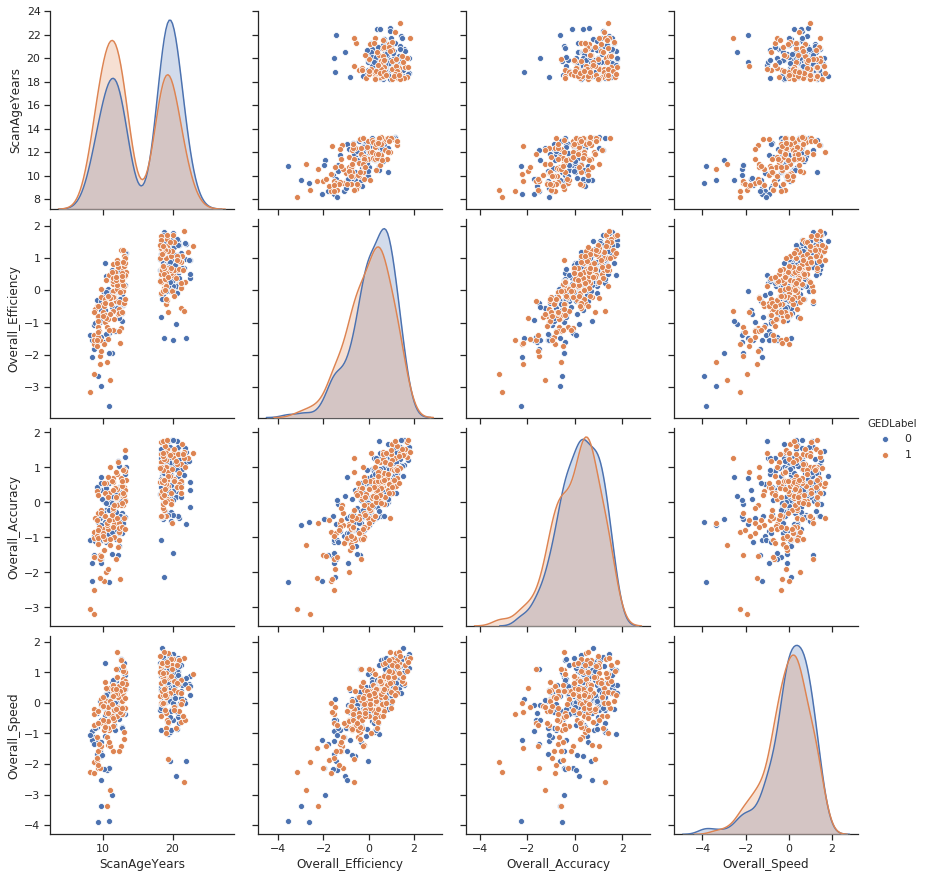

In [153]:
# 'ScanAgeYears', 'Sex', 'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed'
columns = ['GEDLabel', 'ScanAgeYears', 'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed']
sns.pairplot(df_ged[columns], hue='GEDLabel', height=3, aspect=1)

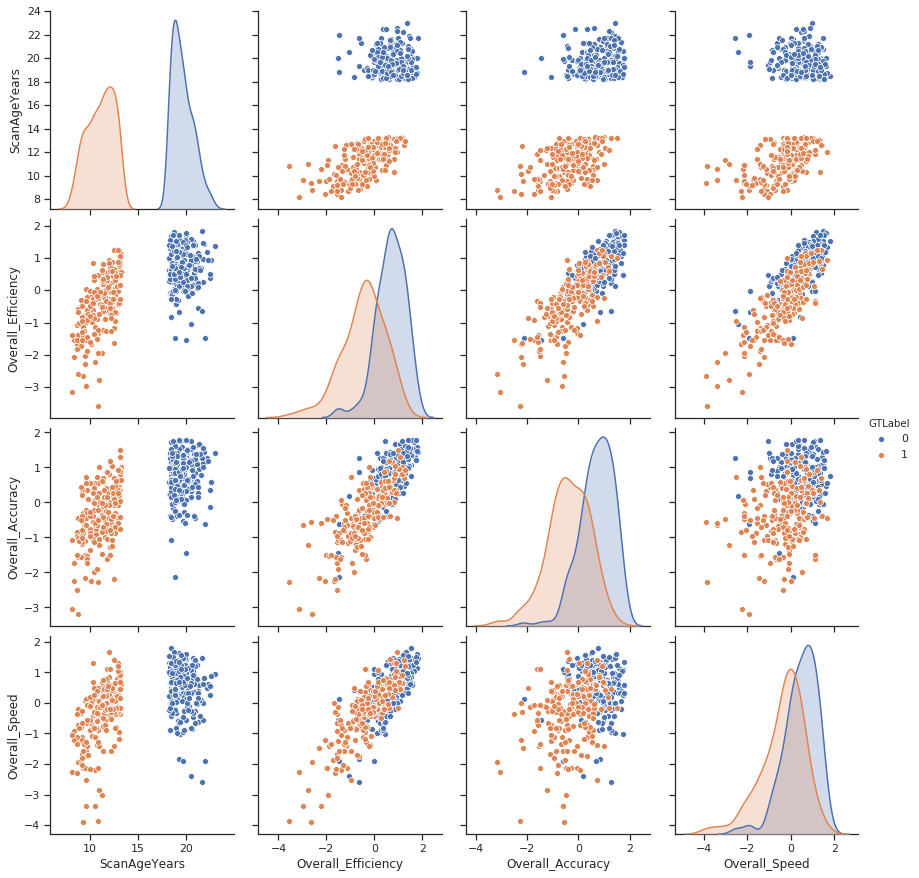

In [157]:
columns = ['GTLabel', 'ScanAgeYears', 'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed']
sns.pairplot(df_ged[columns], hue='GTLabel', height=3, aspect=1)

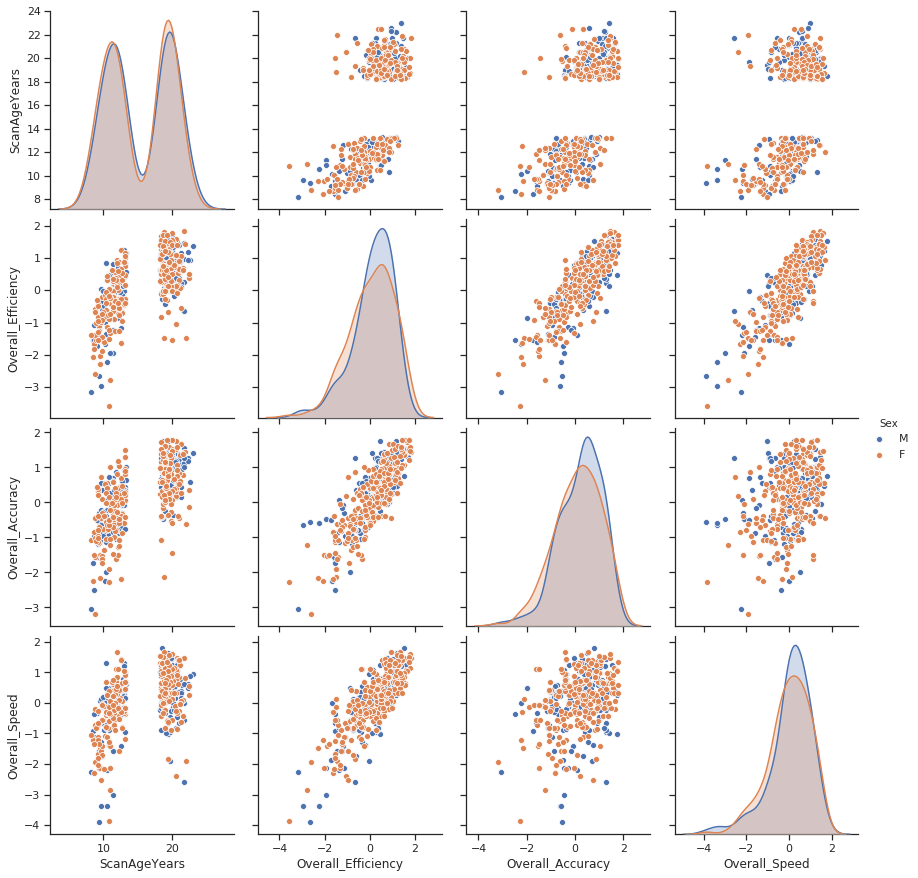

In [159]:
columns = ['Sex', 'ScanAgeYears', 'Overall_Efficiency', 'Overall_Accuracy', 'Overall_Speed']
sns.pairplot(df_ged[columns], hue='Sex', height=3, aspect=1)

In [61]:
class distance_FC(object):
    def __init__(self, FC1, FC2, eig_thresh=10**(-3)):
        self.FC1 = FC1
        self.FC2 = FC2
        self.eig_thresh = eig_thresh

        # ensure symmetric
        self.FC1 = self._ensure_symmetric(self.FC1)
        self.FC2 = self._ensure_symmetric(self.FC2)

    def _ensure_symmetric(self, Q):
        '''
        computation is sometimes not precise (round errors),
        so ensure matrices that are supposed to be
        symmetric are symmetric
        '''
        return (Q + np.transpose(Q))/2

    def _vectorize(self, Q):
        '''
        given a symmetric matrix (FC), return unique
        elements as an array. Ignore diagonal elements
        '''
        # extract lower triangular matrix
        tri = np.tril(Q, -1)

        vec = []
        for ii in range(1, tri.shape[0]):
            for jj in range(ii):
                vec.append(tri[ii, jj])
        
        return np.asarray(vec)

    def geodesic(self):
        '''
        dist = sqrt(trace(log^2(M)))
        M = Q_1^{-1/2}*Q_2*Q_1^{-1/2}
        '''
        # compute Q_1^{-1/2} via eigen value decmposition
        u, s, _ = np.linag.svd(self.FC1, full_matrices=True)

        ## lift very small eigen values
        for ii, s_ii in enumerate(s):
            if s_ii < self.eig_thresh:
                s[ii] = self.eig_thresh

        '''
        since FC1 is in S+, u = v, u^{-1} = u'
        FC1 = usu^(-1)
        FC1^{1/2} = u[s^{1/2}]u'
        FC1^{-1/2} = u[s^{-1/2}]u'
        '''
        FC1_mod = u @ np.diag(s**(-1/2)) @ np.transpose(u)
        M = FC1_mod @ self.FC2 @ FC1_mod

        '''
        trace = sum of eigenvalues;
        np.logm might have round errors,
        implement using svd instead
        '''
        _, s, _ = np.linag.svd(M, full_matrices=True)

        return np.sqrt(np.sum(np.log(s)**2))

    def pearson(self):
        '''
        conventional Pearson distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)

        corr, p = stats.pearsonr(vec1, vec2)
        return (1 - corr)/2, p

    def spearman(self):
        '''
        Spearman distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)

        corr, p = stats.spearmanr(vec1, vec2)
        return (1 - corr)/2, p

    def euclidean(self):
        '''
        Euclidean distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)
        return distance.euclidean(vec1, vec2)

    def canberra(self):
        '''
        Euclidean distance between
        two FC matrices. The matrices are vectorized
        '''
        vec1 = self._vectorize(self.FC1)
        vec2 = self._vectorize(self.FC2)
        return distance.canberra(vec1, vec2)

In [62]:
ged_extreme_dist = 1 - ged_extreme_sim

In [63]:
df = df.reset_index()
df = df.set_index('Subject')
ged_oy = []
ged_oo = []
ged_yy = []

edist_oy = []
edist_oo = []
edist_yy = []

cdist_oy = []
cdist_oo = []
cdist_yy = []

pdist_oy = []
pdist_oo = []
pdist_yy = []
ppval_oy = []
ppval_oo = []
ppval_yy = []

sdist_oy = []
sdist_oo = []
sdist_yy = []
spval_oy = []
spval_oo = []
spval_yy = []

for i in range(len(subj_list_extreme)):
    for j in range(i+1, len(subj_list_extreme)):
        isubj = subj_list_extreme[i]
        jsubj = subj_list_extreme[j]
        iflag = df.loc[isubj]['ScanAgeYears'] > q[0.5]
        jflag = df.loc[jsubj]['ScanAgeYears'] > q[0.5]
        iconn = conn_dict[isubj]['sconn'][0]
        jconn = conn_dict[jsubj]['sconn'][0]
        dist_req = distance_FC(iconn, jconn)
        pdist, ppval = dist_req.pearson()
        sdist, spval = dist_req.spearman()
        edist = dist_req.euclidean()
        cdist = dist_req.canberra()
        if iflag and jflag:
            ged_oo.append(ged_extreme_dist[i,j])
            pdist_oo.append(pdist)
            ppval_oo.append(ppval)
            sdist_oo.append(sdist)
            spval_oo.append(spval)
            edist_oo.append(edist)
            cdist_oo.append(cdist)
        elif not iflag and not jflag:
            ged_yy.append(ged_extreme_dist[i,j])
            pdist_yy.append(pdist)
            ppval_yy.append(ppval)
            sdist_yy.append(sdist)
            spval_yy.append(spval)
            edist_yy.append(edist)
            cdist_yy.append(cdist)
        else:
            ged_oy.append(ged_extreme_dist[i,j])
            pdist_oy.append(pdist)
            ppval_oy.append(ppval)
            sdist_oy.append(sdist)
            spval_oy.append(spval)
            edist_oy.append(edist)
            cdist_oy.append(cdist)


In [94]:
df_dist = pd.DataFrame({'type': ['oy']*len(ged_oy)+['oo']*len(ged_oo)+['yy']*len(ged_yy),
                        'GED': ged_oy+ged_oo+ged_yy,
                        'EuclideanDist': edist_oy+edist_oo+edist_yy,
                        'CanberraDist': cdist_oy+cdist_oo+cdist_yy,
                        'PearsonDist': pdist_oy+pdist_oo+pdist_yy,
                        'PearsonPval': ppval_oy+ppval_oo+ppval_yy,
                        'SpearmanDist': sdist_oy+sdist_oo+sdist_yy,
                        'SpearmanPval': spval_oy+spval_oo+spval_yy})
df_dist['EuclideanDist'] = df_dist['EuclideanDist']/df_dist['EuclideanDist'].max()
df_dist['EuclideanDist'] = df_dist['EuclideanDist']/df_dist['EuclideanDist'].max()

columns = ['GED', 'EuclideanDist', 'CanberraDist', 'PearsonDist', 'SpearmanDist']
tests = ['mean(oy)', 'mean(oo)', 'mean(yy)',
         'std(oy)', 'std(oo)', 'std(yy)',
         't-test_stats(oy/oo)', 't-test_stats(oy/yy)', 't-test_stats(oo/yy)',
         't-test_p(oy/oo)', 't-test_p(oy/yy)', 't-test_p(oo/yy)',
         'welch_stats(oy/oo)', 'welch_stats(oy/yy)', 'welch_stats(oo/yy)',
         'welch_p(oy/oo)', 'welch_p(oy/yy)', 'welch_p(oo/yy)',
         'mannwhitneyu_stats(oy/oo)', 'mannwhitneyu_stats(oy/yy)', 'mannwhitneyu_stats(oo/yy)',
         'mannwhitneyu_p(oy/oo)', 'mannwhitneyu_p(oy/yy)', 'mannwhitneyu_p(oo/yy)',
         'Normality_stats(oy)', 'Normality_stats(oo)', 'Normality_stats(yy)',
         'Normality_p(oy)', 'Normality_p(oo)', 'Normality_p(yy)',
         'ANOVA_stats', 'ANOVA_p']

df_test = pd.DataFrame({'tests': tests})
for column in columns:
    g0 = df_dist[df_dist['type'] == 'oy'][column]
    g1 = df_dist[df_dist['type'] == 'oo'][column]
    g2 = df_dist[df_dist['type'] == 'yy'][column]

    test_score_list = [np.mean(g0), np.mean(g1), np.mean(g2), np.std(g0), np.std(g1), np.std(g2)]

    statistics0, p0 = stats.ttest_ind(g0, g1)
    statistics1, p1 = stats.ttest_ind(g0, g2)
    statistics2, p2 = stats.ttest_ind(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.ttest_ind(g0, g1, equal_var=False)
    statistics1, p1 = stats.ttest_ind(g0, g2, equal_var=False)
    statistics2, p2 = stats.ttest_ind(g1, g2, equal_var=False)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.mannwhitneyu(g0, g1)
    statistics1, p1 = stats.mannwhitneyu(g0, g2)
    statistics2, p2 = stats.mannwhitneyu(g1, g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]

    statistics0, p0 = stats.shapiro(g0)
    statistics1, p1 = stats.shapiro(g1)
    statistics2, p2 = stats.shapiro(g2)
    test_score_list = test_score_list + [statistics0, statistics1, statistics2, p0, p1, p2]
    
    statistics, p = stats.f_oneway(g0, g1, g2)
    test_score_list = test_score_list + [statistics, p]
    
    df_test[column] = test_score_list

df_test.set_index('tests')

/home/sherry/anaconda3/envs/graph/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,GED,EuclideanDist,CanberraDist,PearsonDist,SpearmanDist
tests,,,,,
mean(oy),9.653896e-01,6.015351e-01,2.850392e+03,1.232951e-01,1.565681e-01
mean(oo),9.645131e-01,6.222410e-01,2.817733e+03,1.230600e-01,1.556175e-01
mean(yy),9.657121e-01,5.596258e-01,2.859263e+03,1.176091e-01,1.547727e-01
std(oy),1.731041e-02,5.014518e-02,1.515074e+02,1.960742e-02,1.353383e-02
std(oo),1.773551e-02,4.814786e-02,1.443732e+02,1.650270e-02,1.158707e-02
std(yy),1.724214e-02,4.797736e-02,1.532140e+02,2.202750e-02,1.433810e-02
t-test_stats(oy/oo),5.760674e+00,-4.796814e+01,2.509962e+01,1.445576e+00,8.429196e+00
t-test_stats(oy/yy),-2.182303e+00,9.921401e+01,-6.823955e+00,3.251494e+01,1.520857e+01
t-test_stats(oo/yy),-6.872630e+00,1.305634e+02,-2.793343e+01,2.795012e+01,6.474917e+00


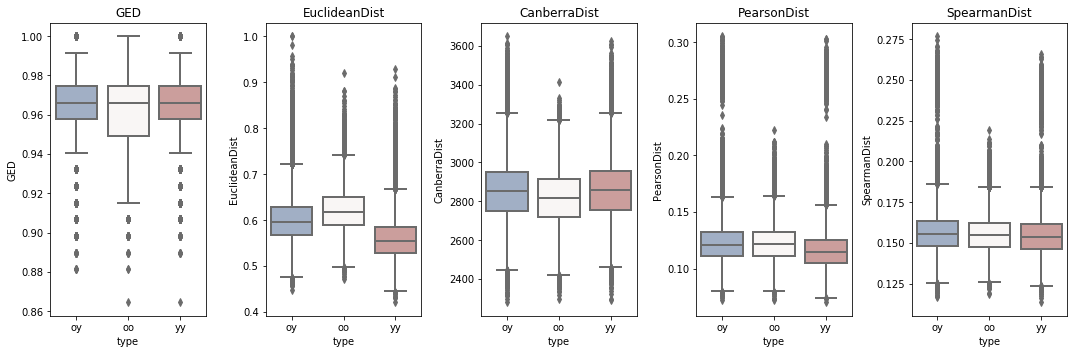

In [95]:
# Box plot
plt.figure(figsize=(15, 5))
columns = ['GED', 'EuclideanDist', 'CanberraDist', 'PearsonDist', 'SpearmanDist']
for i in range(len(columns)):
    plt.subplot(1, 5, i+1)
    params = dict(data=df_dist, x='type', y=columns[i])
    sns.boxplot(palette='vlag', linewidth=2, **params)
    plt.title(columns[i])
plt.tight_layout(pad=1.0)
plt.show()